In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
# export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *
from io import StringIO

In [ ]:
#export
def df2Xy(df, sample_col=None, feat_col=None, data_cols=None, target_col=None, steps_in_rows=False, to3d=True, splits=None,
          sort_by=None, ascending=True, y_func=None, return_names=False):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, and target_col)
    target_col: indicates the column/s where the target is.
    steps_in_rows: flag to indicate if each step is in a different row or in a different column (default).
    to3d: turns X to 3d (including univariate time series)
    sort_by: used to indicate how to sort the dataframe.
    y_func: function used to calculate y for each sample (and target_col)
    return_names: flag to return the names of the columns from where X was generated
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sort_by is not None:
        if isinstance(sort_by, pd.core.indexes.base.Index): sort_by = sort_by.tolist()
        sort_cols += listify(sort_by)
    if sample_col is not None:
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        if sample_col[0] not in sort_cols: sort_cols += listify(sample_col)
        passed_cols += sample_col
    if feat_col is not None:
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        if feat_col[0] not in sort_cols: sort_cols += listify(feat_col)
        passed_cols += feat_col
    if data_cols is not None:
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
    if target_col is not None:
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col
    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if target_col is not None: 
        if any([t for t in target_col if t in data_cols]): print(f"Are you sure you want to include {target_col} in X?")
    if sort_by and sort_cols:
        df.sort_values(sort_cols, ascending=ascending, inplace=True)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None:
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else:
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if to3d:
        if feat_col is not None:
            n_feats = df[feat_col[0]].nunique()
            X = X.reshape(n_samples, n_feats, -1)
        elif steps_in_rows:
            X = X.reshape(n_samples, -1, len(data_cols)).swapaxes(1,2)
        else:
            X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if sample_col is not None:
            y = []
            for tc in target_col:
                _y = np.concatenate(df.groupby(sample_col)[tc].apply(np.array).reset_index()[tc]).reshape(n_samples, -1)
                if y_func is not None: _y = y_func(_y)
                y.append(_y)
            y = np.concatenate(y, -1)
        else:
            y = df[target_col].values
        y = np.squeeze(y)
    else:
        y = None

    # Output
    if splits is None: 
        if return_names: return X, y, data_cols
        else: return X, y
    else: 
        if return_names: return split_xy(X, y, splits), data_cols
        return split_xy(X, y, splits)

In [ ]:
#export  
def split_Xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2xy = df2Xy
split_xy = split_Xy

In [ ]:
df = pd.DataFrame()
df['sample_id'] = np.array([1,1,1,2,2,2,3,3,3])
df['var1'] = df['sample_id'] * 10 + df.index.values
df['var2'] = df['sample_id'] * 100 + df.index.values
df

,sample_id,var1,var2
0,1,10,100
1,1,11,101
2,1,12,102
3,2,23,203
4,2,24,204
5,2,25,205
6,3,36,306
7,3,37,307
8,3,38,308


In [ ]:
X_df, y_df = df2Xy(df, sample_col='sample_id', steps_in_rows=True)
test_eq(X_df[0], np.array([[10, 11, 12], [100, 101, 102]]))

In [ ]:
n_samples = 1_000
n_rows = 10_000

sample_ids = np.arange(n_samples).repeat(n_rows//n_samples).reshape(-1,1)
feat_ids = np.tile(np.arange(n_rows // n_samples), n_samples).reshape(-1,1)
cont = np.random.randn(n_rows, 6)
ind_cat = np.random.randint(0, 3, (n_rows, 1))
target = np.array(['a', 'b', 'c'])[ind_cat]
ind_cat2 = np.random.randint(0, 3, (n_rows, 1))
target2 = np.array(['a', 'b', 'c'])[ind_cat2]
data = np.concatenate([sample_ids, feat_ids, cont, target, target], -1)
columns = ['sample_id', 'feat_id'] + (np.arange(6) + 1).astype(str).tolist() + ['target'] + ['target2']
df = pd.DataFrame(data, columns=columns)
idx = np.random.choice(np.arange(len(df)), len(df), False)
new_dtypes = {'sample_id':np.int32, 'feat_id':np.int32, '1':np.float32, '2':np.float32, '3':np.float32, '4':np.float32, '5':np.float32, '6':np.float32}
df = df.astype(dtype=new_dtypes)
df = df.loc[idx].reset_index(drop=True)
df

,sample_id,feat_id,1,2,3,4,5,6,target,target2
0,774,9,-0.547580,-0.322594,-0.517787,-0.701538,-0.304857,-2.726080,c,c
1,554,2,0.908482,1.714652,-0.714879,-0.199739,0.762379,-0.970568,b,b
2,145,9,-0.911226,0.172659,-0.491488,-0.384408,-0.556632,0.597590,b,b
3,548,6,0.319591,-0.446331,1.484048,0.482792,-0.198063,-0.370612,a,a
4,67,6,-0.348476,-0.192794,-0.154808,0.540674,-1.270303,1.448273,c,c
...,...,...,...,...,...,...,...,...,...,...
9995,191,2,0.837713,1.276311,-0.011582,-0.734673,-0.685720,-0.329007,a,a
9996,256,6,0.210840,0.451456,0.427841,-0.072978,1.859130,1.984713,a,a
9997,26,3,-0.366069,-0.832737,0.910066,0.102232,-1.263237,0.178447,a,a
9998,811,4,0.959656,0.889922,0.760479,-0.385991,2.658971,-0.282682,c,c


In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', data_cols=['1', '2', '3', '4', '5', '6'], target_col=['target'], 
             sort_by=['sample_id', 'feat_id'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000,))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target']].values).mode), y[rand_idx])

In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', target_col=['target', 'target2'], sort_by=['sample_id', 'feat_id'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000, 2))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target', 'target2']].values).mode), y[rand_idx])

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2Xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort_by='sample_id')
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))
X, y

,sample_id,value_0,value_1,target
0,rob,2,3,hot
1,alice,6,7,lukewarm
2,eve,11,12,cold


(array([[[ 6,  7]],
 
        [[11, 12]],
 
        [[ 2,  3]]]),
 array(['lukewarm', 'cold', 'hot'], dtype=object))

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['values'], sort_by='timestep', to3d=True, y_func=y_func)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))
print(X, y)

,sample_id,timestep,values,target
0,rob,1,2,hot
1,alice,1,6,lukewarm
2,eve,1,11,cold
3,rob,2,3,hot
4,alice,2,7,lukewarm
5,eve,2,12,cold


[[[ 6 11]]

 [[ 2  7]]

 [[12  3]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
0,rob,green,2,3,hot
4,alice,green,6,7,lukewarm
2,rob,blue,4,5,hot
9,eve,green,10,11,cold
6,alice,blue,8,9,lukewarm
7,alice,red,9,10,lukewarm
1,rob,yellow,3,4,hot
5,alice,yellow,7,8,lukewarm
3,rob,red,5,6,hot
8,eve,yellow,11,12,cold


[[[ 2  3]
  [ 6  7]
  [ 4  5]
  [10 11]]

 [[ 8  9]
  [ 9 10]
  [ 3  4]
  [ 7  8]]

 [[ 5  6]
  [11 12]
  [12 12]
  [13 14]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], y_func=y_func)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))
print(X, y)

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,hot,good
1,rob,yellow,3,4,hot,good
2,rob,blue,4,5,hot,good
3,rob,red,5,6,hot,good
4,alice,green,6,7,lukewarm,good
5,alice,yellow,7,8,lukewarm,good
6,alice,blue,8,9,lukewarm,good
7,alice,red,9,10,lukewarm,good
8,eve,yellow,11,12,cold,bad
9,eve,green,10,11,cold,bad


[[[ 2  3]
  [ 3  4]
  [ 4  5]
  [ 5  6]]

 [[ 6  7]
  [ 7  8]
  [ 8  9]
  [ 9 10]]

 [[11 12]
  [10 11]
  [12 12]
  [13 14]]] [['lukewarm' 'good']
 ['cold' 'bad']
 ['hot' 'good']]


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
3,rob,red,5,6,hot
9,eve,green,10,11,cold
0,rob,green,2,3,hot
11,eve,red,13,14,cold
5,alice,yellow,7,8,lukewarm
4,alice,green,6,7,lukewarm
6,alice,blue,8,9,lukewarm
2,rob,blue,4,5,hot
7,alice,red,9,10,lukewarm
8,eve,yellow,11,12,cold


[[[ 5  6]
  [10 11]
  [ 2  3]
  [13 14]]

 [[ 7  8]
  [ 6  7]
  [ 8  9]
  [ 4  5]]

 [[ 9 10]
  [11 12]
  [12 12]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', sort_by='timestep', target_col='target', data_cols=['values'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,hot
1,rob,yellow,1,3,hot
2,rob,blue,1,4,hot
3,rob,red,1,5,hot
4,alice,green,1,6,lukewarm
5,alice,yellow,1,7,lukewarm
6,alice,blue,1,8,lukewarm
7,alice,red,1,9,lukewarm
8,eve,yellow,1,11,cold
9,eve,green,1,10,cold


[[[ 8  6]
  [ 9  7]
  [12 10]
  [13 11]]

 [[ 4  2]
  [ 5  3]
  [ 9  7]
  [10  8]]

 [[13 11]
  [14 12]
  [ 5  3]
  [ 6  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# export
def df2np3d(df, groupby, data_cols=None):
    """Transforms a df (with the same number of rows per group in groupby) to a 3d ndarray"""
    if data_cols is None: data_cols = df.columns
    return np.stack([x[data_cols].values for _, x in df.groupby(groupby)]).transpose(0, 2, 1)

In [ ]:
user = np.array([1,2]).repeat(4).reshape(-1,1)
val = np.random.rand(8, 3)
data = np.concatenate([user, val], axis=-1)
df = pd.DataFrame(data, columns=['user', 'x1', 'x2', 'x3'])
test_eq(df2np3d(df, ['user'], ['x1', 'x2', 'x3']).shape, (2, 3, 4))

In [ ]:
# export
def add_missing_value_cols(df, cols=None, dtype=float):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    for col in cols:
        df[f'missing_{col}'] = df[col].isnull().astype(dtype)
    return df

In [ ]:
data = np.random.randn(10, 2)
mask = data > .8
data[mask] = np.nan
df = pd.DataFrame(data, columns=['A', 'B'])
df = add_missing_value_cols(df, cols=None, dtype=float)
test_eq(df['A'].isnull().sum(), df['missing_A'].sum())
test_eq(df['B'].isnull().sum(), df['missing_B'].sum())
df

,A,B,missing_A,missing_B
0,-0.280405,-0.260789,0.0,0.0
1,0.395735,0.437631,0.0,0.0
2,-1.203534,0.342320,0.0,0.0
3,0.357521,-0.082145,0.0,0.0
4,-0.141506,NaN,0.0,1.0
5,-0.250680,0.305447,0.0,0.0
6,0.040467,-0.438127,0.0,0.0
7,-0.915562,NaN,0.0,1.0
8,-1.312690,0.605581,0.0,0.0
9,NaN,-1.817455,1.0,0.0


In [ ]:
# export

def add_missing_timestamps(df, datetime_col, groupby=None, fill_value=np.nan, range_by_group=True, freq=None):
    """Fills missing timestamps in a dataframe to a desired frequency
    Args:
        df:                      pandas DataFrame
        datetime_col:            column that contains the datetime data (without duplicates within groups)
        groupby:                 column used to identify unique_ids
        fill_value:              values that will be insert where missing dates exist. Default:np.nan
        range_by_group:          if True, dates will be filled between min and max dates for each group. Otherwise, between the min and max dates in the df.
        freq:                    frequence used to fillin the missing datetime
    """
    if is_listy(datetime_col): 
        assert len(datetime_col) == 1, 'you can only pass a single datetime_col'
        datetime_col = datetime_col[0]
    dates = pd.date_range(df[datetime_col].min(), df[datetime_col].max(), freq=freq)
    if groupby is not None:
        if is_listy(groupby): 
            assert len(groupby) == 1, 'you can only pass a single groupby'
            groupby = groupby[0]
        keys = df[groupby].unique()
        if range_by_group:
            # Fills missing dates between min and max for each unique id
            min_dates = df.groupby(groupby)[datetime_col].min()
            max_dates = df.groupby(groupby)[datetime_col].max()
            idx_tuples = flatten_list([[(d, key) for d in pd.date_range(min_date, max_date, freq=freq)] for min_date, max_date, key in \
                                       zip(min_dates, max_dates, keys)])
            multi_idx = pd.MultiIndex.from_tuples(idx_tuples, names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan).reset_index()
        else:
            # Fills missing dates between min and max - same for all unique ids
            multi_idx = pd.MultiIndex.from_product((dates, keys), names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan)
            df = df.reset_index().sort_values(by=[groupby, datetime_col]).reset_index(drop=True)
    else: 
        index = pd.Index(dates, name=datetime_col)
        df = df.set_index([datetime_col]).reindex(index, fill_value=fill_value)
        df = df.reset_index().reset_index(drop=True)
    return df

In [ ]:
# Filling dates between min and max dates
dates = pd.date_range('2021-05-01', '2021-05-07').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates

,date,feature1,feature2
0,2021-05-01,0.570133,0.491085
1,2021-05-03,0.299671,0.098674
2,2021-05-05,0.789253,0.600440
3,2021-05-06,0.923072,0.049045
4,2021-05-07,0.029552,0.058429


In [ ]:
# No groups
expected_output_df = date_df.copy()
expected_output_df.loc[[1,3], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby=None, 
                                   fill_value=np.nan, 
                                   range_by_group=False)
test_eq(output_df, expected_output_df)

,date,feature1,feature2
0,2021-05-01,0.570133,0.491085
1,2021-05-02,NaN,NaN
2,2021-05-03,0.299671,0.098674
3,2021-05-04,NaN,NaN
4,2021-05-05,0.789253,0.600440
5,2021-05-06,0.923072,0.049045
6,2021-05-07,0.029552,0.058429


In [ ]:
# Filling dates between min and max dates for each value in groupby column
dates = pd.date_range('2021-05-01', '2021-05-07').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,3,8,11,13]).reset_index(drop=True)

date_df_with_missing_dates

,date,id,feature1,feature2
0,2021-05-03,0,0.340887,0.867545
1,2021-05-05,0,0.704899,0.522582
2,2021-05-06,0,0.939294,0.024675
3,2021-05-07,0,0.972052,0.320195
4,2021-05-01,1,0.637823,0.373266
5,2021-05-03,1,0.487708,0.868869
6,2021-05-04,1,0.450943,0.606067
7,2021-05-06,1,0.174891,0.263581


In [ ]:
# groupby='id', range_by_group=True
expected_output_df = date_df.drop([0,1,13]).reset_index(drop=True)  
expected_output_df.loc[[1,6,9], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=True)
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-03,0,0.340887,0.867545
1,2021-05-04,0,NaN,NaN
2,2021-05-05,0,0.704899,0.522582
3,2021-05-06,0,0.939294,0.024675
4,2021-05-07,0,0.972052,0.320195
5,2021-05-01,1,0.637823,0.373266
6,2021-05-02,1,NaN,NaN
7,2021-05-03,1,0.487708,0.868869
8,2021-05-04,1,0.450943,0.606067
9,2021-05-05,1,NaN,NaN


In [ ]:
# groupby='id', range_by_group=False
expected_output_df = date_df.copy() 
expected_output_df.loc[[0,1,3,8,11,13], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=False)
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-01,0,NaN,NaN
1,2021-05-02,0,NaN,NaN
2,2021-05-03,0,0.340887,0.867545
3,2021-05-04,0,NaN,NaN
4,2021-05-05,0,0.704899,0.522582
5,2021-05-06,0,0.939294,0.024675
6,2021-05-07,0,0.972052,0.320195
7,2021-05-01,1,0.637823,0.373266
8,2021-05-02,1,NaN,NaN
9,2021-05-03,1,0.487708,0.868869


In [ ]:
# Filling dates between min and max timestamps
dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates

,date,feature1,feature2
0,2021-05-01 00:00:00,0.031292,0.751733
1,2021-05-01 08:00:00,0.086646,0.913205
2,2021-05-01 16:00:00,0.494394,0.697216
3,2021-05-01 20:00:00,0.225196,0.512351


In [ ]:
# No groups
expected_output_df = date_df.copy()
expected_output_df.loc[[1,3], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 'date', groupby=None, fill_value=np.nan, range_by_group=False, freq='4H')
test_eq(output_df, expected_output_df)

,date,feature1,feature2
0,2021-05-01 00:00:00,0.031292,0.751733
1,2021-05-01 04:00:00,NaN,NaN
2,2021-05-01 08:00:00,0.086646,0.913205
3,2021-05-01 12:00:00,NaN,NaN
4,2021-05-01 16:00:00,0.494394,0.697216
5,2021-05-01 20:00:00,0.225196,0.512351


In [ ]:
# Filling missing values between min and max timestamps for each value in groupby column

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,3,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.413664,0.464574
1,2021-05-01 16:00:00,0,0.994041,0.523935
2,2021-05-01 20:00:00,0,0.623664,0.969163
3,2021-05-01 00:00:00,1,0.247239,0.028919
4,2021-05-01 04:00:00,1,0.325881,0.857786
5,2021-05-01 16:00:00,1,0.416783,0.032183


In [ ]:
# groupby='id', range_by_group=True
expected_output_df = date_df.drop([0,1,11]).reset_index(drop=True)  
expected_output_df.loc[[1,6,7], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=True, 
                                   freq='4H')
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.413664,0.464574
1,2021-05-01 12:00:00,0,NaN,NaN
2,2021-05-01 16:00:00,0,0.994041,0.523935
3,2021-05-01 20:00:00,0,0.623664,0.969163
4,2021-05-01 00:00:00,1,0.247239,0.028919
5,2021-05-01 04:00:00,1,0.325881,0.857786
6,2021-05-01 08:00:00,1,NaN,NaN
7,2021-05-01 12:00:00,1,NaN,NaN
8,2021-05-01 16:00:00,1,0.416783,0.032183


In [ ]:
# groupby='id', range_by_group=False
expected_output_df = date_df.copy() 
expected_output_df.loc[[0,1,3,8,9,11], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=False, 
                                   freq='4H')
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-01 00:00:00,0,NaN,NaN
1,2021-05-01 04:00:00,0,NaN,NaN
2,2021-05-01 08:00:00,0,0.413664,0.464574
3,2021-05-01 12:00:00,0,NaN,NaN
4,2021-05-01 16:00:00,0,0.994041,0.523935
5,2021-05-01 20:00:00,0,0.623664,0.969163
6,2021-05-01 00:00:00,1,0.247239,0.028919
7,2021-05-01 04:00:00,1,0.325881,0.857786
8,2021-05-01 08:00:00,1,NaN,NaN
9,2021-05-01 12:00:00,1,NaN,NaN


In [ ]:
# No groups, with duplicate dates ==> FAILS
dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby=None, fill_value=np.nan, range_by_group=False, freq='4H'), 
          contains='cannot reindex from a duplicate axis')

,date,feature1,feature2
0,2021-05-01 00:00:00,0.683876,0.215380
1,2021-05-01 08:00:00,0.078827,0.629144
2,2021-05-01 16:00:00,0.720622,0.078572
3,2021-05-01 16:00:00,0.226382,0.483996


In [ ]:
# groupby='id', range_by_group=True, with duplicate dates ==> FAILS

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby='id', fill_value=np.nan, range_by_group=True, freq='4H'), 
          contains='cannot handle a non-unique multi-index!')

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.573107,0.918289
1,2021-05-01 12:00:00,0,0.431797,0.820472
2,2021-05-01 16:00:00,0,0.101609,0.846490
3,2021-05-01 16:00:00,0,0.420314,0.990483
4,2021-05-01 00:00:00,1,0.289379,0.112901
5,2021-05-01 04:00:00,1,0.726047,0.298620
6,2021-05-01 16:00:00,1,0.851139,0.834290


In [ ]:
# groupby='id', range_by_group=FALSE, with duplicate dates ==> FAILS

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby='id', fill_value=np.nan, range_by_group=False, freq='4H'), 
          contains='cannot handle a non-unique multi-index!')

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.531203,0.581064
1,2021-05-01 12:00:00,0,0.253524,0.528130
2,2021-05-01 16:00:00,0,0.644885,0.538795
3,2021-05-01 16:00:00,0,0.300767,0.217810
4,2021-05-01 00:00:00,1,0.060197,0.555205
5,2021-05-01 04:00:00,1,0.916742,0.855112
6,2021-05-01 16:00:00,1,0.139602,0.029200


In [ ]:
# export
def time_encoding(series, freq, max_val=None):
    """Transforms a pandas series of dtype datetime64 (of any freq) or DatetimeIndex into 2 float arrays
    
    Available options: microsecond, millisecond, second, minute, hour, day = day_of_month = dayofmonth, 
    day_of_week = weekday = dayofweek, day_of_year = dayofyear, week = week_of_year = weekofyear, month and year
    """

    if freq == 'day_of_week' or freq == 'weekday': freq = 'dayofweek'
    elif freq == 'day_of_month' or freq == 'dayofmonth': freq = 'day'
    elif freq == 'day_of_year': freq = 'dayofyear'
    available_freqs = ['microsecond', 'millisecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'week', 'month', 'year']
    assert freq in available_freqs
    if max_val is None:
        idx = available_freqs.index(freq)
        max_val = [1_000_000, 1_000, 60, 60, 24, 31, 7, 366, 53, 12, 10][idx]
    try:
        series = series.to_series()
    except:
        pass
    if freq == 'microsecond': series = series.dt.microsecond
    elif freq == 'millisecond': series = series.dt.microsecond // 1_000
    elif freq == 'second': series = series.dt.second
    elif freq == 'minute': series = series.dt.minute
    elif freq == 'hour': series = series.dt.hour
    elif freq == 'day': series = series.dt.day
    elif freq == 'dayofweek': series = series.dt.dayofweek
    elif freq == 'dayofyear': series = series.dt.dayofyear
    elif freq == 'week': series = series.dt.isocalendar().week
    elif freq == 'month': series = series.dt.month
    elif freq == 'year': series = series.dt.year - series.dt.year // 10 * 10
    sin = np.sin(series.values / max_val * 2 * np.pi)
    cos = np.cos(series.values / max_val * 2 * np.pi)
    return sin, cos

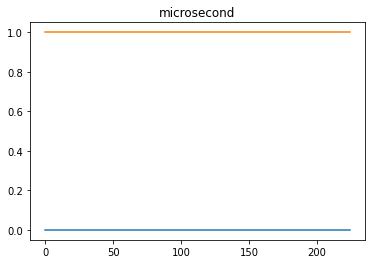

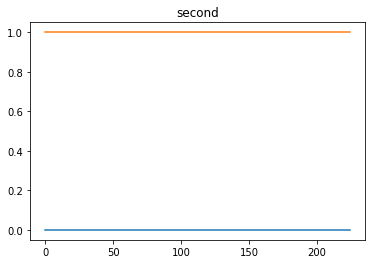

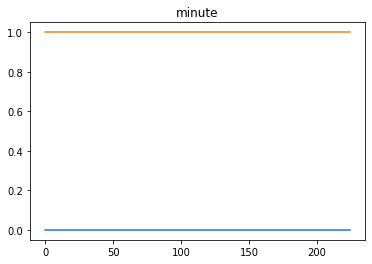

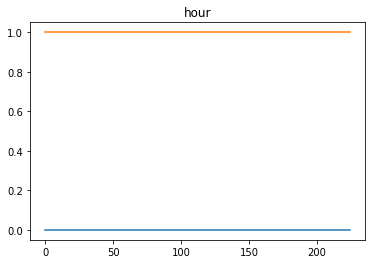

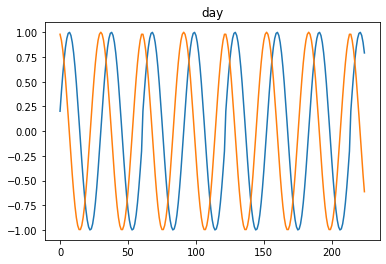

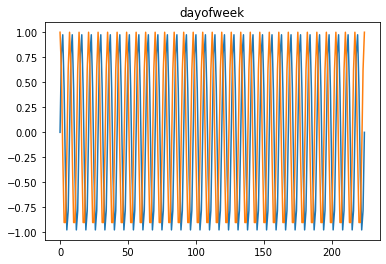

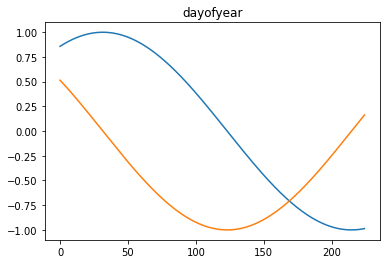

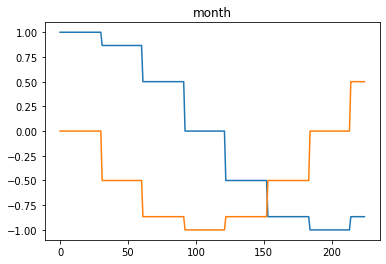

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    tdf = pd.DataFrame(pd.date_range('2021-03-01', datetime.today()), columns=['date'])
    a,b = time_encoding(tdf.date, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

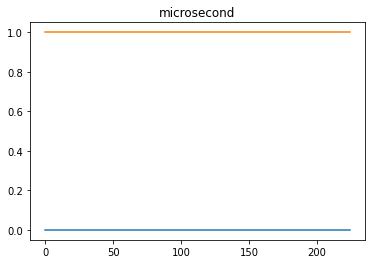

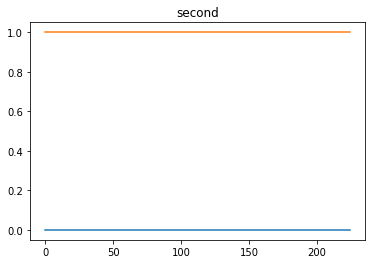

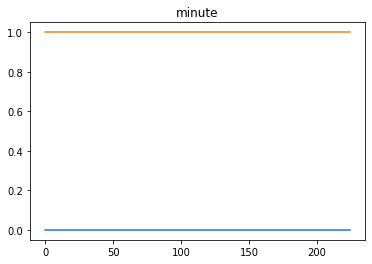

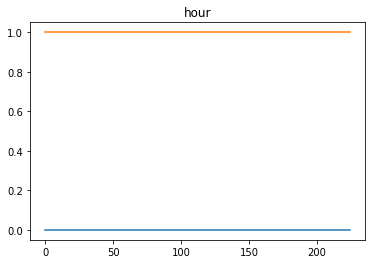

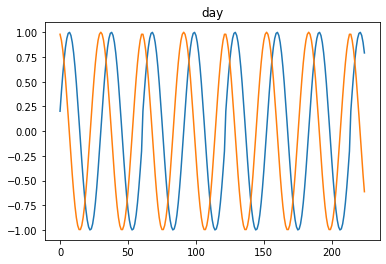

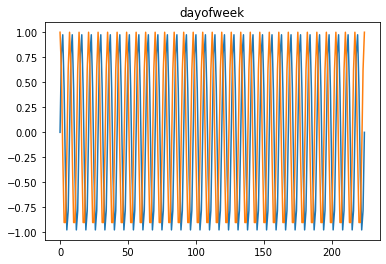

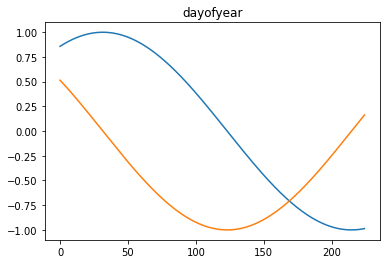

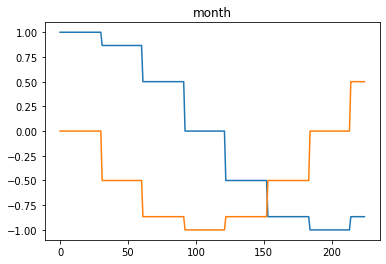

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    dateindex = pd.date_range('2021-03-01', datetime.today())
    a,b = time_encoding(dateindex, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

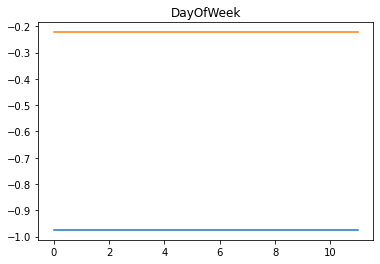

,date,id,feature1,feature2,dow_sin,dow_cos
0,2021-05-01 00:00:00,0,0.894659,0.014184,-0.974928,-0.222521
1,2021-05-01 04:00:00,0,0.445358,0.556357,-0.974928,-0.222521
2,2021-05-01 08:00:00,0,0.531203,0.581064,-0.974928,-0.222521
3,2021-05-01 12:00:00,0,0.253524,0.528130,-0.974928,-0.222521
4,2021-05-01 16:00:00,0,0.644885,0.538795,-0.974928,-0.222521
5,2021-05-01 20:00:00,0,0.300767,0.217810,-0.974928,-0.222521
6,2021-05-01 00:00:00,1,0.060197,0.555205,-0.974928,-0.222521
7,2021-05-01 04:00:00,1,0.916742,0.855112,-0.974928,-0.222521
8,2021-05-01 08:00:00,1,0.737059,0.798004,-0.974928,-0.222521
9,2021-05-01 12:00:00,1,0.273099,0.078595,-0.974928,-0.222521


In [ ]:
dow_sin, dow_cos = time_encoding(date_df['date'], 'dayofweek')
plt.plot(dow_sin)
plt.plot(dow_cos)
plt.title('DayOfWeek')
plt.show()
date_df['dow_sin'] = dow_sin
date_df['dow_cos'] = dow_cos
date_df

In [ ]:
# export

def forward_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps since previous real value along the last dimension of 3D arrays or tensors"""

    b,c,s=o.shape
    if isinstance(o, torch.Tensor):
        idx = torch.where(o==o, torch.arange(s, device=o.device), 0)
        idx = torch.cummax(idx, axis=-1).values
        gaps = 1 + (torch.arange(s, device=o.device).reshape(1,1,-1).repeat(b, c, 1) - idx).float()
        mask = torch.isnan(o[torch.arange(b, device=o.device)[:,None, None], torch.arange(c, device=o.device)[None, :, None], idx])
    elif isinstance(o, np.ndarray):
        idx = np.where(o==o, np.arange(s), 0)
        idx = np.maximum.accumulate(idx,axis=-1)
        gaps = 1 + (np.arange(s).reshape(1,1,-1).repeat(b, 0).repeat(c, 1) - idx).astype(float)
        mask = np.isnan(o[np.arange(b)[:,None, None], np.arange(c)[None, :, None], idx])
    gaps[mask] = nan_to_num
    if normalize:
        gaps[gaps > 0] = gaps[gaps > 0] / s
    return gaps


def backward_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps to next real value along the last dimension of 3D arrays or tensors"""

    if isinstance(o, torch.Tensor): o = torch_flip(o, -1)
    elif isinstance(o, np.ndarray): o = o[..., ::-1]
    gaps = forward_gaps(o, nan_to_num=nan_to_num, normalize=normalize)
    if isinstance(o, torch.Tensor): gaps = torch_flip(gaps, -1)
    elif isinstance(o, np.ndarray): gaps = gaps[..., ::-1]
    return gaps


def nearest_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps to nearest real value along the last dimension of 3D arrays or tensors"""

    forward = forward_gaps(o, nan_to_num=np.nan, normalize=normalize)
    backward = backward_gaps(o, nan_to_num=np.nan, normalize=normalize)
    if isinstance(o, torch.Tensor):
        gaps = torch.fmin(forward, backward)
        gaps[torch.isnan(gaps)] = nan_to_num
        return gaps
    elif isinstance(o, np.ndarray):
        gaps = np.fmin(forward, backward)
        gaps[np.isnan(gaps)] = nan_to_num
        return gaps


def get_gaps(o : Tensor, nan_to_num : int = 0, forward : bool = True, backward : bool = True, 
             nearest : bool = True, normalize : bool = True):
    """Number of sequence steps from previous, to next and/or to nearest real value along the 
    last dimension of 3D arrays or tensors"""
    
    _gaps = []
    if forward or nearest:  
        fwd = forward_gaps(o, nan_to_num=np.nan, normalize=normalize)
        if forward: 
            _gaps.append(fwd)
    if backward or nearest: 
        bwd = backward_gaps(o, nan_to_num=np.nan, normalize=normalize)
        if backward: 
            _gaps.append(bwd)
    if nearest:
        if isinstance(o, torch.Tensor): 
            nst = torch.fmin(fwd, bwd)
        elif isinstance(o, np.ndarray): 
            nst = np.fmin(fwd, bwd)
        _gaps.append(nst)
    if isinstance(o, torch.Tensor): 
        gaps = torch.cat(_gaps, 1)
        gaps[torch.isnan(gaps)] = nan_to_num
    elif isinstance(o, np.ndarray):
        gaps = np.concatenate(_gaps, 1)
        gaps[np.isnan(gaps)] = nan_to_num
    return gaps

In [ ]:
t = torch.rand(1, 2, 8)
arr = t.numpy()
t[t <.6] = np.nan
test_ge(nearest_gaps(t).min().item(), 0)
test_ge(nearest_gaps(arr).min(), 0)
test_le(nearest_gaps(t).min().item(), 1)
test_le(nearest_gaps(arr).min(), 1)
test_eq(torch.isnan(forward_gaps(t)).sum(), 0)
test_eq(np.isnan(forward_gaps(arr)).sum(), 0)
ag = get_gaps(t)
test_eq(ag.shape, (1,6,8))
test_eq(torch.isnan(ag).sum(), 0)

In [ ]:
# export

def add_delta_timestamp_cols(df, cols=None, groupby=None, forward=True, backward=True, nearest=True, nan_to_num=0, normalize=True):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    if forward or nearest:
        if groupby:
            forward_time_gaps = df[cols].groupby(df[groupby]).apply(lambda x: forward_gaps(x.values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize))
            forward_time_gaps = np.concatenate(forward_time_gaps, -1)[0].transpose(1,0)
        else:
            forward_time_gaps = forward_gaps(df[cols].values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize)[0].transpose(1,0)
        if forward : 
            df[[f'{col}_dt_fwd' for col in cols]] = forward_time_gaps
            df[[f'{col}_dt_fwd' for col in cols]] = df[[f'{col}_dt_fwd' for col in cols]].fillna(nan_to_num)
    if backward or nearest:
        if groupby:
            backward_time_gaps = df[cols].groupby(df[groupby]).apply(lambda x: backward_gaps(x.values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize))
            backward_time_gaps = np.concatenate(backward_time_gaps, -1)[0].transpose(1,0)
        else:
            backward_time_gaps = backward_gaps(df[cols].values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize)[0].transpose(1,0)
        if backward: 
            df[[f'{col}_dt_bwd' for col in cols]] = backward_time_gaps
            df[[f'{col}_dt_bwd' for col in cols]] = df[[f'{col}_dt_bwd' for col in cols]].fillna(nan_to_num)
    if nearest:
        df[[f'{col}_dt_nearest' for col in cols]] = np.fmin(forward_time_gaps, backward_time_gaps)
        df[[f'{col}_dt_nearest' for col in cols]] = df[[f'{col}_dt_nearest' for col in cols]].fillna(nan_to_num)
    return df


In [ ]:
# Add delta timestamp features for the no groups setting
dates = pd.date_range('2021-05-01', '2021-05-07').values
data = np.zeros((len(dates), 2))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))

cols = ['date', 'feature1']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float})
date_df.loc[[1,3,4],'feature1'] = np.nan

In [ ]:
# No groups

normalize = 1/len(dates)
expected_output_df = date_df.copy()
expected_output_df['feature1_dt_fwd'] = normalize
expected_output_df.loc[[1,3,4], 'feature1_dt_fwd'] = np.array([2,2,3]) * normalize

expected_output_df['feature1_dt_bwd'] = normalize
expected_output_df.loc[[1,3,4], 'feature1_dt_bwd'] = np.array([2,3,2]) * normalize

expected_output_df['feature1_dt_nearest'] = normalize
expected_output_df.loc[[1,3,4], 'feature1_dt_nearest'] =np.array([2,2,2]) * normalize

display(expected_output_df)
output_df = add_delta_timestamp_cols(date_df, cols='feature1')
test_eq(expected_output_df, output_df)

,date,feature1,feature1_dt_fwd,feature1_dt_bwd,feature1_dt_nearest
0,2021-05-01,0.863330,0.142857,0.142857,0.142857
1,2021-05-02,NaN,0.285714,0.285714,0.285714
2,2021-05-03,0.371371,0.142857,0.142857,0.142857
3,2021-05-04,NaN,0.285714,0.428571,0.285714
4,2021-05-05,NaN,0.428571,0.285714,0.285714
5,2021-05-06,0.887573,0.142857,0.142857,0.142857
6,2021-05-07,0.543243,0.142857,0.142857,0.142857


In [ ]:
# Add delta timestamp features within a group
dates = pd.date_range('2021-05-01', '2021-05-07').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))

cols = ['date', 'id', 'feature1']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float})
date_df.loc[[1,3,4,8,9,11],'feature1'] = np.nan

In [ ]:
# groupby='id'

normalize = 2/len(dates)
expected_output_df = date_df.copy()
expected_output_df['feature1_dt_fwd'] = normalize
expected_output_df.loc[[1,3,4,8,9,11], 'feature1_dt_fwd'] = np.array([2,2,3,2,3,2]) * normalize

expected_output_df['feature1_dt_bwd'] = normalize
expected_output_df.loc[[1,3,4,8,9,11], 'feature1_dt_bwd'] = np.array([2,3,2,3,2,2]) * normalize

expected_output_df['feature1_dt_nearest'] = normalize
expected_output_df.loc[[1,3,4,8,9,11], 'feature1_dt_nearest'] =np.array([2,2,2,2,2,2]) * normalize

display(expected_output_df)
output_df = add_delta_timestamp_cols(date_df, cols='feature1', groupby='id')
test_eq(expected_output_df, output_df)

,date,id,feature1,feature1_dt_fwd,feature1_dt_bwd,feature1_dt_nearest
0,2021-05-01,0,0.085427,0.142857,0.142857,0.142857
1,2021-05-02,0,NaN,0.285714,0.285714,0.285714
2,2021-05-03,0,0.902418,0.142857,0.142857,0.142857
3,2021-05-04,0,NaN,0.285714,0.428571,0.285714
4,2021-05-05,0,NaN,0.428571,0.285714,0.285714
5,2021-05-06,0,0.302807,0.142857,0.142857,0.142857
6,2021-05-07,0,0.921649,0.142857,0.142857,0.142857
7,2021-05-01,1,0.950945,0.142857,0.142857,0.142857
8,2021-05-02,1,NaN,0.285714,0.428571,0.285714
9,2021-05-03,1,NaN,0.428571,0.285714,0.285714


In [ ]:
# export
# # SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# # https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, pad_remainder:bool=False, padding_value:float=np.nan, add_padding_feature:bool=True,
                  get_x:Union[None, int, list]=None, get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, copy:bool=False,
                  horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    Args:
        window_len          = length of lookback window
        stride              = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start               = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder       = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        padding_value       = value (float) that will be used for padding. Default: np.nan
        add_padding_feature = add an additional feature indicating whether each timestep is padded (1) or not (0).
        horizon             = number of future datapoints to predict:
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x               = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y               = indices of columns that contain the target (ys). If None, all data will be used as y.
                            [] means no y data is created (unlabeled data).
        y_func              = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        copy                = copy the original object to avoid changes in it.
        seq_first           = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by             = column/s used for sorting the array in ascending order
        ascending           = used in sorting
        check_leakage       = checks if there's leakage in the output between X and y
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage:
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    if stride == 0 or stride is None:
        stride = window_len

    def _inner(o):
        if copy: 
            if isinstance(o, torch.Tensor):  o = o.clone()
            else: o = o.copy()
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame):
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            if get_x is None: X = o.values
            elif isinstance(o.columns[0], str): X = o.loc[:, _get_x].values
            else: X = o.iloc[:, _get_x].values
            if get_y == []: y = None
            elif get_y is None: y = o.values 
            elif isinstance(o.columns[0], str): y = o.loc[:, _get_y].values  
            else: y = o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            if get_x is None: X = o
            else: X = o[:, _get_x]
            if get_y == []: y = None
            elif get_y is None: y = o
            else: y = o[:, _get_y]
        seq_len = len(X)
        if get_y != []:
            X_max_time = seq_len - start - window_len - max_horizon - pad_remainder
        else:
            X_max_time = seq_len - start - window_len - pad_remainder
        if pad_remainder:
            if add_padding_feature:
                X = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)
            X_max_time = X_max_time - X_max_time % stride + stride
            if window_len + start + X_max_time - len(X) >= 0:
                _X = np.empty((window_len + start + X_max_time - len(X), *X.shape[1:]))
                _X[:] = padding_value
                if add_padding_feature:
                    _X[:, -1] = 1
                X = np.concatenate((X, _X))
        elif X_max_time < 0: return None, None
        X_sub_windows = (start +
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time + 1, step=stride), 0).T
                        ) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))
        if get_y != [] and y is not None:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon - pad_remainder
            div = 0
            if pad_remainder:
                div = y_max_time % stride
                y_max_time = y_max_time - y_max_time % stride + stride
                if window_len + start + y_max_time - len(y) >= 0:
                    _y = np.empty((window_len + start + y_max_time - len(y), *y.shape[1:]))
                    _y[:] = padding_value
                    y = np.concatenate((y, _y))
            y_sub_windows = (y_start +
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time + div, step=stride), 0).T
                            ) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0:
                y = y_func(y)
            if y.ndim >= 2:
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            if y.ndim == 3:
                y = y.transpose(0, 2, 1)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X

input shape: (13, 3)


array([[[ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [ 0.,  0.,  0.,  1.,  1.]]])

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,tensor(0),tensor(0),tensor(0)
1,tensor(1),tensor(10),tensor(100)
2,tensor(2),tensor(20),tensor(200)
3,tensor(3),tensor(30),tensor(300)
4,tensor(4),tensor(40),tensor(400)
5,tensor(5),tensor(50),tensor(500)
6,tensor(6),tensor(60),tensor(600)
7,tensor(7),tensor(70),tensor(700)
8,tensor(8),tensor(80),tensor(800)
9,tensor(9),tensor(90),tensor(900)


[(array([[tensor(0), tensor(1), tensor(2), tensor(3), tensor(4)],
       [tensor(0), tensor(10), tensor(20), tensor(30), tensor(40)],
       [tensor(0), tensor(100), tensor(200), tensor(300), tensor(400)]],
      dtype=object), array([tensor(5), tensor(50), tensor(500)], dtype=object)), (array([[tensor(1), tensor(2), tensor(3), tensor(4), tensor(5)],
       [tensor(10), tensor(20), tensor(30), tensor(40), tensor(50)],
       [tensor(100), tensor(200), tensor(300), tensor(400), tensor(500)]],
      dtype=object), array([tensor(6), tensor(60), tensor(600)], dtype=object)), (array([[tensor(2), tensor(3), tensor(4), tensor(5), tensor(6)],
       [tensor(20), tensor(30), tensor(40), tensor(50), tensor(60)],
       [tensor(200), tensor(300), tensor(400), tensor(500), tensor(600)]],
      dtype=object), array([tensor(7), tensor(70), tensor(700)], dtype=object)), (array([[tensor(3), tensor(4), tensor(5), tensor(6), tensor(7)],
       [tensor(30), tensor(40), tensor(50), tensor(60), tensor(70)]

In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y="var_0")(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,tensor(0),tensor(0),tensor(0)
1,tensor(1),tensor(10),tensor(100)
2,tensor(2),tensor(20),tensor(200)
3,tensor(3),tensor(30),tensor(300)
4,tensor(4),tensor(40),tensor(400)
5,tensor(5),tensor(50),tensor(500)
6,tensor(6),tensor(60),tensor(600)
7,tensor(7),tensor(70),tensor(700)
8,tensor(8),tensor(80),tensor(800)
9,tensor(9),tensor(90),tensor(900)


[(array([[tensor(0), tensor(1), tensor(2), tensor(3), tensor(4)],
       [tensor(0), tensor(10), tensor(20), tensor(30), tensor(40)],
       [tensor(0), tensor(100), tensor(200), tensor(300), tensor(400)]],
      dtype=object), tensor(5)), (array([[tensor(1), tensor(2), tensor(3), tensor(4), tensor(5)],
       [tensor(10), tensor(20), tensor(30), tensor(40), tensor(50)],
       [tensor(100), tensor(200), tensor(300), tensor(400), tensor(500)]],
      dtype=object), tensor(6)), (array([[tensor(2), tensor(3), tensor(4), tensor(5), tensor(6)],
       [tensor(20), tensor(30), tensor(40), tensor(50), tensor(60)],
       [tensor(200), tensor(300), tensor(400), tensor(500), tensor(600)]],
      dtype=object), tensor(7)), (array([[tensor(3), tensor(4), tensor(5), tensor(6), tensor(7)],
       [tensor(30), tensor(40), tensor(50), tensor(60), tensor(70)],
       [tensor(300), tensor(400), tensor(500), tensor(600), tensor(700)]],
      dtype=object), tensor(8)), (array([[tensor(4), tensor(5), ten

In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,tensor(0),tensor(0),tensor(0)
1,tensor(1),tensor(10),tensor(100)
2,tensor(2),tensor(20),tensor(200)
3,tensor(3),tensor(30),tensor(300)
4,tensor(4),tensor(40),tensor(400)
5,tensor(5),tensor(50),tensor(500)
6,tensor(6),tensor(60),tensor(600)
7,tensor(7),tensor(70),tensor(700)
8,tensor(8),tensor(80),tensor(800)
9,tensor(9),tensor(90),tensor(900)


[(array([[tensor(0), tensor(1), tensor(2), tensor(3), tensor(4)],
       [tensor(0), tensor(10), tensor(20), tensor(30), tensor(40)]],
      dtype=object), tensor(500)), (array([[tensor(1), tensor(2), tensor(3), tensor(4), tensor(5)],
       [tensor(10), tensor(20), tensor(30), tensor(40), tensor(50)]],
      dtype=object), tensor(600)), (array([[tensor(2), tensor(3), tensor(4), tensor(5), tensor(6)],
       [tensor(20), tensor(30), tensor(40), tensor(50), tensor(60)]],
      dtype=object), tensor(700)), (array([[tensor(3), tensor(4), tensor(5), tensor(6), tensor(7)],
       [tensor(30), tensor(40), tensor(50), tensor(60), tensor(70)]],
      dtype=object), tensor(800)), (array([[tensor(4), tensor(5), tensor(6), tensor(7), tensor(8)],
       [tensor(40), tensor(50), tensor(60), tensor(70), tensor(80)]],
      dtype=object), tensor(900))]


(1000, 3)


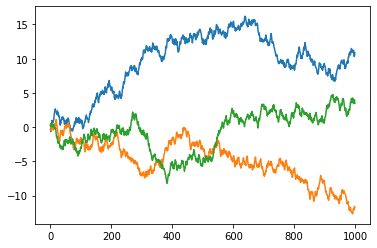

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,-0.143433,0.067383,-0.322384
1,0.125569,-0.035499,0.122545
2,0.386088,-0.322483,-0.082623
3,-0.016405,0.139778,-0.049701
4,0.273837,-0.196200,-0.422563
...,...,...,...
95,-1.699558,0.784182,-2.394763
96,-2.141294,1.205599,-2.479853
97,-2.243731,1.660394,-2.608459
98,-2.531154,2.129217,-3.074207


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.241578,-0.139497,-0.209630,-0.488207,0.206813
1,-0.112960,0.170740,0.061980,-0.571339,0.642125
2,0.164673,0.054314,0.429260,-0.754368,0.926570
3,-0.259837,0.052043,0.437559,-0.939774,0.629008
4,-0.145209,0.525226,0.153002,-1.174136,0.778769
...,...,...,...,...,...
95,0.051256,2.366806,6.305224,-2.196649,-2.612089
96,0.072497,2.007037,6.124045,-2.163542,-2.438121
97,-0.420240,1.897900,5.868862,-1.902812,-2.292299
98,-0.257165,1.947196,6.035096,-1.903642,-1.995038


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.174846,0.225418,0.268775,0.762375,0.993641,1.101865,1.192837,1.174811,0.939405,1.200174,...,7.246061,7.028605,7.064231,7.435738,7.413363,7.333702,7.540150,7.538507,7.050447,6.874891
var_1,0.013261,-0.340979,-0.564327,-1.006574,-1.504171,-1.369898,-1.126103,-1.578854,-1.706633,-1.480206,...,0.162339,0.576135,0.961963,1.361295,1.791274,1.833676,1.513763,1.267967,0.984343,0.484673
var_2,0.207041,-0.003330,0.069720,-0.190343,-0.095879,-0.141769,0.244075,0.434960,0.366369,0.452914,...,-4.842034,-4.758667,-4.549763,-4.224505,-3.728968,-3.561049,-3.513912,-3.938917,-3.705505,-3.982333
var_3,-0.155030,-0.079529,-0.316490,-0.013203,-0.106059,-0.167481,-0.097740,-0.179122,0.239924,0.274228,...,0.923244,1.106250,0.678090,0.685469,0.273056,0.226976,0.126250,0.537397,0.631305,0.347365
target,-0.406426,-0.045982,-0.415706,-0.469376,-0.516411,-0.759720,-1.236874,-1.635173,-1.478889,-1.200043,...,-5.533716,-5.714341,-5.907830,-6.059038,-5.797292,-5.736822,-6.078461,-6.556608,-6.483759,-6.258090


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.267797,-0.141813,-0.470875,-0.895711,-1.270986,-1.163044,-1.269634,-1.609618,-1.207874,-1.671321,...,-4.356021,-4.512423,-4.139520,-4.639205,-4.778109,-4.781969,-4.598857,-4.624421,-4.973130,-5.406765
var_1,0.313641,-0.185759,-0.266796,-0.537080,-0.734062,-0.662933,-0.973501,-0.966157,-1.255219,-0.881260,...,-2.318942,-2.336956,-1.949525,-1.661791,-1.362659,-1.763148,-1.518884,-1.781844,-1.291333,-0.874664
var_2,-0.427103,-0.415429,-0.674767,-0.312796,0.033024,0.079522,-0.183694,-0.158674,0.160061,-0.216618,...,-3.679843,-3.860656,-4.218569,-4.636212,-4.267539,-4.411076,-4.741823,-4.405905,-4.392459,-4.647824
var_3,-0.267810,-0.584874,-1.068457,-0.817120,-0.956469,-0.901785,-0.583272,-1.079119,-1.513763,-1.457664,...,-3.065513,-2.812351,-2.898863,-2.873633,-2.671375,-2.789048,-3.152642,-3.555018,-3.119779,-2.831542
target,0.329978,0.736233,0.308676,0.106681,0.141862,0.622253,0.870895,1.232773,1.559130,1.329486,...,0.283081,0.300029,0.714006,0.786206,1.222304,1.236261,0.776093,0.973854,1.005276,1.193194


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.254320,-0.358343,-0.119323,0.495726,-0.068078
1,-0.104356,-0.172275,0.050247,0.359814,-0.113509
2,-0.322910,0.106147,-0.159862,0.116725,-0.010271
3,0.133597,0.519132,-0.150723,0.139786,0.289347
4,0.218536,0.485921,-0.436888,-0.126651,0.678668
...,...,...,...,...,...
95,-2.501643,2.964334,-0.701324,-0.275237,-2.622359
96,-2.435676,2.622644,-0.262516,0.083341,-2.753307
97,-2.314858,2.663131,-0.382278,-0.149831,-2.635767
98,-2.680872,2.230411,-0.688229,-0.308263,-2.371873


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
data = np.concatenate([np.linspace(0, 1, 11).reshape(-1,1).repeat(2, 1), np.arange(11).reshape(-1,1)], -1)
df_test = pd.DataFrame(data, columns=['col1', 'col2', 'target'])
df_test['target'] = df_test['target'].astype(int)
df_test

,col1,col2,target
0,0.0,0.0,0
1,0.1,0.1,1
2,0.2,0.2,2
3,0.3,0.3,3
4,0.4,0.4,4
5,0.5,0.5,5
6,0.6,0.6,6
7,0.7,0.7,7
8,0.8,0.8,8
9,0.9,0.9,9


In [ ]:
def _y_func(o): return o[:, 0]

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=_y_func)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)
    test_close(x[:, 0, 0]*10, y)

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/ wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, len(df_test)+1):
    x, y = SlidingWindow(wl, None, pad_remainder=False, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 2)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, 20):
    x, _ = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=[])(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(2, len(df_test)):
    x, _ = SlidingWindow(wl, wl, pad_remainder=False, get_x=['col1', 'col2'], get_y=[])(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[1], 2)
    test_eq(x.shape[2], wl)

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0,
                       pad_remainder:bool=False, padding_value:float=np.nan, add_padding_feature:bool=True,
                       get_x:Union[None, int, list]=None,  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, copy:bool=False,
                       horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None, ascending:bool=True,
                       check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.

    Args:
        window_len          = length of lookback window
        unique_id_cols      = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride              = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start               = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder       = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        padding_value       = value (float) that will be used for padding. Default: np.nan
        add_padding_feature = add an additional feature indicating whether each timestep is padded (1) or not (0).
        horizon             = number of future datapoints to predict:
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x               = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y               = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
        y_func              = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        copy                = copy the original object to avoid changes in it.
        seq_first           = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by             = column/s used for sorting the array in ascending order
        ascending           = used in sorting
        check_leakage       = checks if there's leakage in the output between X and y
        return_key          = when True, the key corresponsing to unique_id_cols for each sample is returned
        verbose             = controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.


    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if not is_listy(unique_id_cols): unique_id_cols = [unique_id_cols]
    if sort_by is not None and not  is_listy(sort_by): sort_by = [sort_by]
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])

    def _SlidingWindowPanel(o):

        if copy: 
            o = o.copy()
        o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = o[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, pad_remainder=pad_remainder, padding_value=padding_value,
                                     add_padding_feature=add_padding_feature, get_x=get_x, get_y=get_y, y_func=y_func,
                                     horizon=horizon, seq_first=seq_first,
                                     check_leakage=check_leakage)(o[(o[unique_id_cols].values == v).sum(axis=1) == len(v)])
            if x_v is not None and len(x_v) > 0:
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            elif verbose>=2:
                print(f'cannot use {unique_id_cols} = {v} due to not having enough records')

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key:
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y

    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,tensor(61656),tensor(616542),tensor(6165402),tensor(61654000),tensor(616540000),tensor(6165400000),tensor(61654000000),tensor(616540000000),tensor(6165400000000),tensor(61654000000000),61654,2,2,B,161658
1,tensor(12784),tensor(127822),tensor(1278202),tensor(12782000),tensor(127820000),tensor(1278200000),tensor(12782000000),tensor(127820000000),tensor(1278200000000),tensor(12782000000000),12782,2,3,B,112786
2,tensor(70264),tensor(702640),tensor(7026400),tensor(70264000),tensor(702640000),tensor(7026400000),tensor(70264000000),tensor(702640000000),tensor(7026400000000),tensor(70264000000000),70264,0,1,A,70264
3,tensor(68176),tensor(681760),tensor(6817600),tensor(68176000),tensor(681760000),tensor(6817600000),tensor(68176000000),tensor(681760000000),tensor(6817600000000),tensor(68176000000000),68176,0,1,A,68176
4,tensor(65912),tensor(659120),tensor(6591200),tensor(65912000),tensor(659120000),tensor(6591200000),tensor(65912000000),tensor(659120000000),tensor(6591200000000),tensor(65912000000000),65912,0,0,A,65912


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199982, 10, 5), (199982,))

In [ ]:
# export

def identify_padding(float_mask, value=-1):
    """Identifies padded subsequences in a mask of type float
    
    This function identifies as padded subsequences those where all values == nan 
    from the end of the sequence (last dimension) across all channels, and sets
    those values to the selected value (default = -1)
    
    Args:
        mask: boolean or float mask
        value: scalar that will be used to identify padded subsequences 
    """
    padding = torch.argmax((torch.flip(float_mask.mean((1)) - 1, (-1,)) != 0).float(), -1)
    padded_idxs = torch.arange(len(float_mask))[padding != 0]
    if len(padded_idxs) > 0:
        padding = padding[padding != 0]
        for idx,pad in zip(padded_idxs, padding): float_mask[idx, :, -pad:] = value
    return float_mask

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, _ = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X = tensor(X)
X[0, 1, -2:] = np.nan
X[1,..., :3] = np.nan
print(X)
identify_padding(torch.isnan(X).float())

input shape: (13, 3)
tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  1.,  2., nan, nan],
         [ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  0.,  0.,  0.,  0.]],

        [[nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  0.,  0.]],

        [[10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [ 0.,  0.,  0.,  1.,  1.]]])


tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.]],

        [[0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.]]])

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);

<IPython.core.display.Javascript object>

011_data.preparation.ipynb saved at 2021-10-11 20:47:09.
Converted 011_data.preparation.ipynb.


Correct conversion! 😃
Total time elapsed 0.092 s
Monday 11/10/21 20:47:13 CEST
